In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from Deep_Learning.Experimental.Boltzmann.train import train, eval
from Deep_Learning.Experimental.Boltzmann.rbm import RestrictedBoltzmannMachine
from Utils.dataset import PreloadedDataset
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else "cpu"
# device = torch.device('cpu')
device

device(type='cuda')

In [3]:
x = torch.randn(100, 784)
vis_bias = torch.randn(784)
(x @ vis_bias).shape

torch.Size([100])

In [4]:
# Sets vals < 0.0 -> 0.0 and vals >= 0.0 -> 1.0
class HopfieldActivation():
    def __call__(self, x, _=None):
        return hopfield_activation(x)

def hopfield_activation(x: torch.Tensor, threshold:float=0.0):
    x = torch.clamp(x, max=0.0)
    x = torch.sign(x)
    x += 1.0
    return x

class MixSamples():
    def __init__(self, dataset):
        self.dataset = dataset
        self.n = len(dataset)
    def __call__(self, x, _=None):
        i = torch.randint(0, self.n-1, (x.shape[0],))
        return mix_images(x, self.dataset[i][0])

def mix_images(x1, x2, steps=10):
    mask = torch.bernoulli(torch.ones((28,28))*0.5).unsqueeze(0).unsqueeze(0)
    # blur  with a filter of the form [1/4, 1/2, 1/4] in both horizontal and veritical directions
    filter_h = torch.tensor([[1/4, 1/2, 1/4]])
    filter_v = torch.tensor([[1/4], [1/2], [1/4]])
    for _ in range(5):
        mask = F.conv2d(mask, filter_h.unsqueeze(0).unsqueeze(0), padding='same')
        mask = F.conv2d(mask, filter_v.unsqueeze(0).unsqueeze(0), padding='same')
    
    # threshold at 0.5
    mask_1 = mask > 0.5
    mask_2 = mask <= 0.5

    out = x1*mask_1 + x2*mask_2
    return out.squeeze(0)

  0%|          | 0/60000 [00:00<?, ?it/s]

Loaded MNIST with 60000 samples


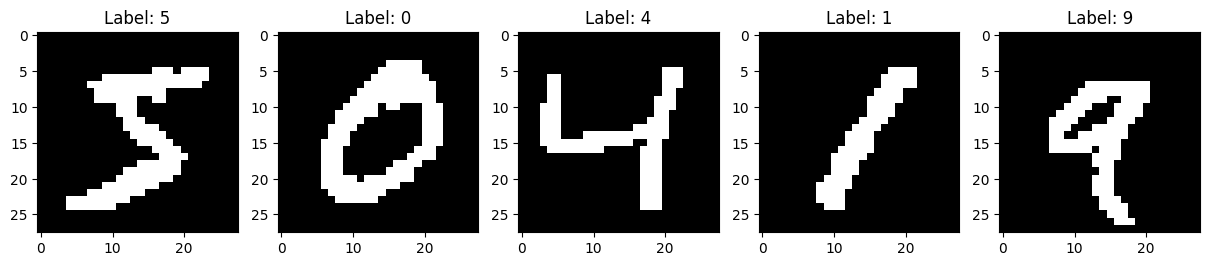

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    HopfieldActivation(),
])

subset_size = 60000
dataset = datasets.MNIST(root="../Datasets/", train=True, transform=transform, download=False)
dataset = torch.utils.data.Subset(dataset, range(subset_size))

positive_dataset = PreloadedDataset.from_dataset(dataset, None, device)
# negative_dataset = PreloadedDataset.from_dataset(dataset, MixSamples(dataset), device)
print(f'Loaded MNIST with {len(positive_dataset)} samples')

# show first samples positives
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axs[i].imshow(np.squeeze(positive_dataset[i][0].cpu().numpy()), cmap='gray')
    axs[i].set_title(f"Label: {positive_dataset[i][1]}")
plt.show()

# show first samples negatives
# import matplotlib.pyplot as plt
# import numpy as np
# fig, axs = plt.subplots(1, 5, figsize=(15, 5))
# for i in range(5):
#     axs[i].imshow(np.squeeze(negative_dataset[i][0].numpy()), cmap='gray')
#     axs[i].set_title(f"Label: {negative_dataset[i][1]}")
# plt.show()

In [6]:
def train(
    model,
    optimiser,
    train_dataset,
    batch_size,
    errors,
    losses,
    epochs,
    steps,
):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        epoch_errors = []
        epoch_losses = []
        loop = tqdm(train_loader, total=len(train_loader), leave=False)

        if epoch > 0:
            loop.set_description(f"Epoch {epoch+1}/{epochs} - error: {errors[-1]:.4f}")

        for i, (x, _) in enumerate(loop):
            x = x.flatten(1)

            out = model(x, steps=steps)
            error = F.mse_loss(out, x)
            loss = model.free_energy(x) - model.free_energy(out)

            model.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_errors.append(error.item())
            epoch_losses.append(loss.item())

        errors.append(sum(epoch_errors)/len(epoch_errors))
        losses.append(sum(epoch_losses)/len(epoch_losses))

In [16]:
model = RestrictedBoltzmannMachine(784, 500, temp_k=0.1, device=device)
errors = []
losses = []

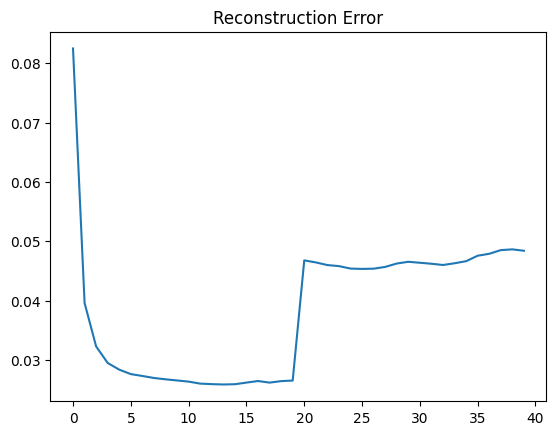

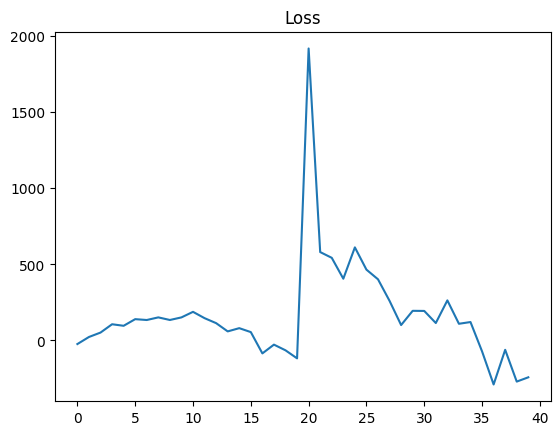

In [55]:
optimiser = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.001)
# optimiser = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)
train(
    model,
    optimiser,
    positive_dataset,
    64,
    errors,
    losses,
    epochs=20,
    steps=3,
)

plt.plot(errors)
plt.title('Reconstruction Error')
plt.show()

plt.plot(losses)
plt.title('Loss')
plt.show()

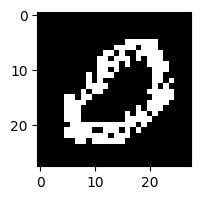

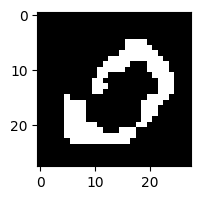

In [70]:
x = positive_dataset[torch.randint(0, len(positive_dataset), (1,))][0]
x = x * torch.bernoulli(torch.ones_like(x)*0.8)
# x = x + torch.randn_like(x)*0.2
x = (x + x.min() / (x.max() - x.min()))

# show x in 1 of 2 

plt.figure(figsize=(2,2))
plt.imshow(np.squeeze(x.cpu().numpy()), cmap='gray')
plt.show()

# x = model.reconstruct(x.view(1, -1), max_steps=100, mean_field=False).view(1, 28, 28)
x = model(x.flatten(1), steps=10).view(1, 28, 28)

# show x
plt.figure(figsize=(2,2))
plt.imshow(np.squeeze(x.cpu().detach().numpy()), cmap='gray')
plt.show()

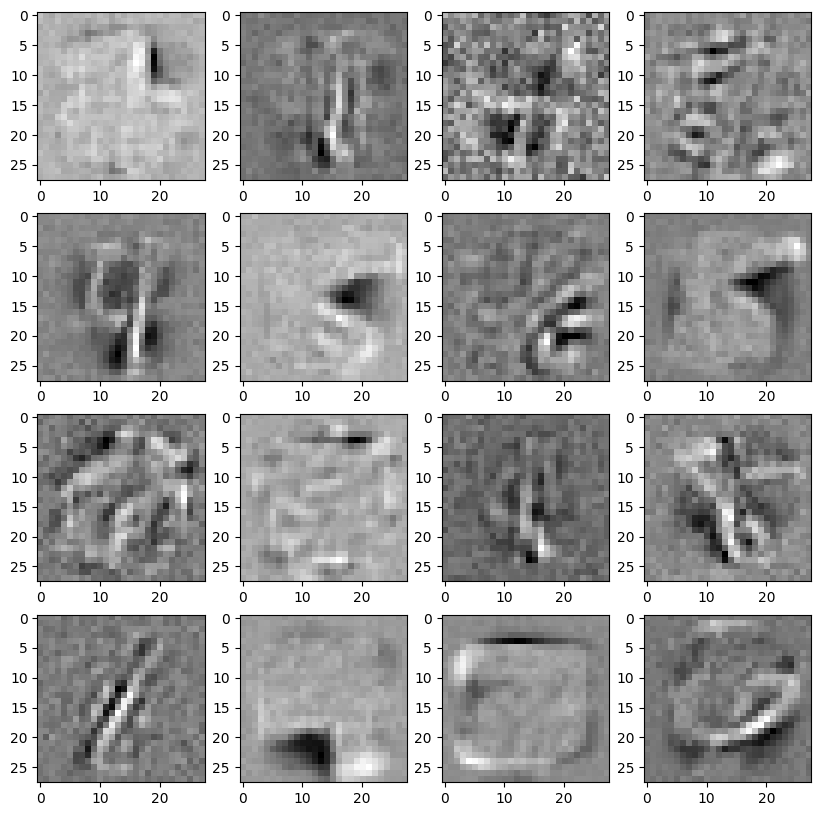

In [76]:
# view first 16 features
features = model.weights.T[:16,:].view(16, 28, 28)

fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(np.squeeze(features[i*4+j].cpu().detach().numpy()), cmap='gray')
plt.show()

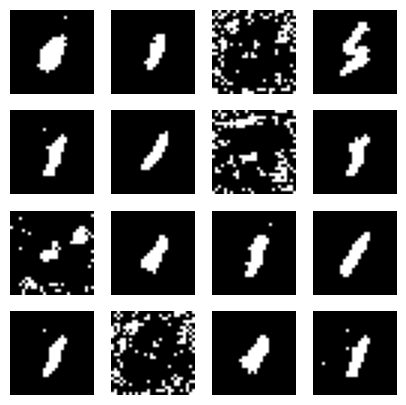

In [48]:
imgs = model.generate(16, steps=100, mean_field=False).view(-1, 28, 28)

fig, axs = plt.subplots(4, 4, figsize=(5, 5))
for i in range(16):
    axs[i//4, i%4].imshow(np.squeeze(imgs[i].cpu().detach().numpy()), cmap='gray')
    axs[i//4, i%4].axis('off')
plt.show()